In [1]:
## original code from https://biapol.github.io/Image-data-science-with-Python-and-Napari-EPFL2022/day2d_image_segmentation/12_Segmentation_3D.html
## env setting to see https://github.com/clEsperanto/pyclesperanto_prototype/tree/master

In [2]:
from skimage.io import imread
from skimage.io import imsave
from skimage import filters
from skimage import morphology
from pyclesperanto_prototype import imshow
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt

In [ ]:
import napari
from napari.utils import nbscreenshot

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from skimage import measure

In [ ]:
import os
os.getcwd()

In [ ]:
cle.available_device_names()

In [ ]:
# For 3D processing, powerful graphics
# processing units might be necessary
cle.select_device('TX')

In [8]:
def show(image_to_show, labels=False):
    """
    This function generates three projections: in X-, Y- and Z-direction and shows them.
    """
    projection_x = cle.maximum_x_projection(image_to_show)
    projection_y = cle.maximum_y_projection(image_to_show)
    projection_z = cle.maximum_z_projection(image_to_show)

    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    cle.imshow(projection_x, plot=axs[0], labels=labels)
    cle.imshow(projection_y, plot=axs[1], labels=labels)
    cle.imshow(projection_z, plot=axs[2], labels=labels)
    plt.show()


In [ ]:
############################################################
###
### Pax6 KO
### counting the voxels based on the masked and cyst-level background 
###
############################################################

In [8]:
ImageDir = "../images_data/d4_10x_Pax6KO_WTchim/original"
ImageDir = "../images_data/d4_10x_Pax6KO_WTchim/test_jetraw_compression"
outDir = "../images_data/results/Pax6KO_WTchim_d4"

if not os.path.exists(outDir):
    os.mkdir(outDir)

In [115]:
fileName = '241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F9_95_01_isotropic'

In [116]:
mask = imread(os.path.join(CPoutDir, str(fileName + "_C5_CystMask.tiff"))) # mask segmeted cysts
#C1 = imread(os.path.join(CPoutDir, str(fileName + "_FoxA2mask.tiff"))) # FoxA2, nuclei
#C2 = imread(os.path.join(CPoutDir, str(fileName + "_P6KOSCmask.tiff"))) # Pax6-KO genotype Scarlet, nuclei
#C3 = imread(os.path.join(CPoutDir, str(fileName + "_WTGFPmask.tiff"))) # WT genotype GFP, whole cell 
#C4 = imread(os.path.join(CPoutDir, str(fileName + "_Pax6mask.tiff"))) # Pax6, nuclei
C1 = imread(os.path.join(ImageDir, str(fileName + "_C1.tif"))) # FoxA2, nuclei
C2 = imread(os.path.join(ImageDir, str(fileName + "_C2.tif"))) # Pax6-KO genotype Scarlet, nuclei
C3 = imread(os.path.join(ImageDir, str(fileName + "_C3.tif"))) # WT genotype GFP, whole cell 
C4 = imread(os.path.join(ImageDir, str(fileName + "_C4.tif"))) # Pax6, nuclei

In [117]:
C1 = C1 / np.quantile(C1, 0.99)
C2 = C2 / np.quantile(C2, 0.99)
C3 = C3 / np.quantile(C3, 0.99)
C4 = C4 / np.quantile(C4, 0.99)

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/image_py3.9/lib/python3.9/site-packages/pyclesperanto_prototype/_tier9/_imshow.py:35: UserWarning: cle.imshow is deprecated, use stackview.imshow instead.
  warnings.warn("cle.imshow is deprecated, use stackview.imshow instead.")


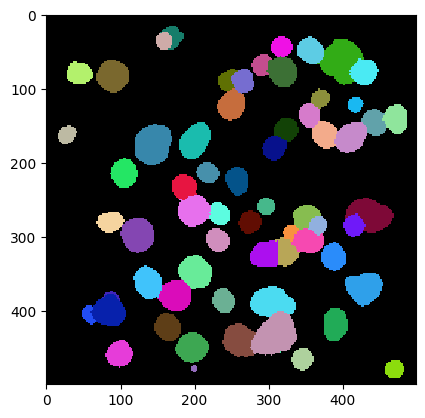

In [43]:
projection_z = cle.maximum_z_projection(mask)
cle.imshow(projection_z, labels=True)

In [118]:
from skimage import measure
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank

labels_mask, nb_cyst = measure.label(mask, return_num = True)

In [23]:
np.max(mask)
np.min(mask)
np.unique(mask)
np.unique(C3)
np.unique(C3)

array([6.34075201e-05, 1.26815040e-04, 1.90222560e-04, ...,
       3.28374865e+00, 3.31177478e+00, 3.32547080e+00])

In [24]:
nb_cyst

64

In [120]:
#local_otsu = rank.otsu(img, footprint)
#global_otsu = img >= threshold_global_otsu
cutoff_wt = threshold_otsu(C3)
cutoff_ko = threshold_otsu(C2)
cutoff_foxa2 = threshold_otsu(C1)
cutoff_pax6 = threshold_otsu(C4)
print(cutoff_wt, cutoff_ko, cutoff_foxa2, cutoff_pax6)

0.5001735037806734 0.4327891607704403 0.44733443161801717 0.6657661769701086


In [91]:
cyst_index = np.where(labels_mask == 4)
print(cyst_index[0].size)
genotype_wt = C3[cyst_index]
genotype_ko = C2[cyst_index]
pax6 = C4[cyst_index]
foxa2 = C1[cyst_index]

19348


In [98]:
cutoff_wt = threshold_otsu(genotype_wt)
print(cutoff_wt)
cutoff_ko = threshold_otsu(genotype_ko)
print(cutoff_ko)
cutoff_foxa2 = threshold_otsu(foxa2)
print(cutoff_foxa2)
cutoff_pax6 = threshold_otsu(pax6)
print(cutoff_pax6, cutoff_wt)

0.7223228651480565
0.01966330090408805
0.2925899859503439
1.1475432022758154 0.7223228651480565


In [93]:
sels = np.where((genotype_wt > cutoff_wt) | (genotype_ko > cutoff_ko))

genotype_wt_sels = genotype_wt[sels]
genotype_ko_sels = genotype_ko[sels]
pax6_sels = pax6[sels]
foxa2_sels = foxa2[sels]
sels[0].size
index_wt = np.where(genotype_wt_sels > genotype_ko_sels) # compare GFP with Scarlet in the scaled intensities # this worth checking how many are double positive (to do)
print(index_wt[0].size/sels[0].size)

foxa2_wt = foxa2_sels[index_wt]
pax6_wt = pax6_sels[index_wt]

index_foxa2 = np.where((foxa2_wt > cutoff_foxa2) & (pax6_wt < cutoff_pax6))
index_pax6 = np.where((foxa2_wt < cutoff_foxa2) & (pax6_wt > cutoff_pax6)) ##
index_double = np.where((foxa2_wt > cutoff_foxa2) & (pax6_wt > cutoff_pax6))

print(index_foxa2[0].size/(index_foxa2[0].size + index_pax6[0].size + index_double[0].size))



0.988474684047373
0.1169076052796983


In [9]:
import pandas as pd
from skimage import measure
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank
from skimage import filters
from skimage import measure
data = {"image": [], "cyst_index": [], "cyst_size": [],  "pct_genotype": [], "pct_wt": [], "pct_foxa2": [], "pct_pax6": [],  
        "cutoff_wt": [],  "cutoff_ko": [],  "cutoff_foxa2": [],  "cutoff_pax6": []}
df = pd.DataFrame(data)
df

,image,cyst_index,cyst_size,pct_genotype,pct_wt,pct_foxa2,pct_pax6,cutoff_wt,cutoff_ko,cutoff_foxa2,cutoff_pax6


In [10]:
for nm in os.listdir(ImageDir):
    if "_C5_CystMask.tiff" in nm:
        #print(nm)
        fileName = nm.replace('_C5_CystMask.tiff','')
        #files += [nm]
        print(fileName)
        #make_composite_C5(newName, ImageDir, outDir)
        
        mask = imread(os.path.join(ImageDir, str(fileName + "_C5_CystMask.tiff"))) # mask segmeted cysts
        #C1 = imread(os.path.join(CPoutDir, str(fileName + "_FoxA2mask.tiff"))) # FoxA2, nuclei
        #C2 = imread(os.path.join(CPoutDir, str(fileName + "_P6KOSCmask.tiff"))) # Pax6-KO genotype Scarlet, nuclei
        #C3 = imread(os.path.join(CPoutDir, str(fileName + "_WTGFPmask.tiff"))) # WT genotype GFP, whole cell 
        #C4 = imread(os.path.join(CPoutDir, str(fileName + "_Pax6mask.tiff"))) # Pax6, nuclei
        C1 = imread(os.path.join(ImageDir, str(fileName + "_C1.tif"))) # FoxA2, nuclei
        C2 = imread(os.path.join(ImageDir, str(fileName + "_C2.tif"))) # Pax6-KO genotype Scarlet, nuclei
        C3 = imread(os.path.join(ImageDir, str(fileName + "_C3.tif"))) # WT genotype GFP, whole cell 
        C4 = imread(os.path.join(ImageDir, str(fileName + "_C4.tif"))) # Pax6, nuclei
        
        C1 = C1 / np.quantile(C1, 0.95)
        C2 = C2 / np.quantile(C2, 0.95)
        C3 = C3 / np.quantile(C3, 0.95)
        C4 = C4 / np.quantile(C4, 0.95)
        
        props_C1 = measure.regionprops_table(
                    labels_mask, 
                    intensity_image = C1,
                    properties=('label', 'centroid',  
                    'intensity_max')
        )
        #cutoff_wt = threshold_otsu(C3)
        #cutoff_ko = threshold_otsu(C2)
        #cutoff_foxa2 = threshold_otsu(C1)
        #cutoff_pax6 = threshold_otsu(C4)
        #print(cutoff_wt, cutoff_ko, cutoff_foxa2, cutoff_pax6)
        
        labels_mask, nb_cyst = measure.label(mask, return_num = True)
       
        for i in range(nb_cyst+1):
            if i > 0:
                cyst_index = np.where(labels_mask == i)
                #print(cyst_index[0].size)
                genotype_wt = C3[cyst_index]
                genotype_ko = C2[cyst_index]
                foxa2 = C1[cyst_index]
                pax6 = C4[cyst_index]
                
                cutoff_wt = threshold_otsu(genotype_wt)
                cutoff_ko = threshold_otsu(genotype_ko)
                #cutoff_foxa2 = threshold_otsu(foxa2)
                #cutoff_pax6 = threshold_otsu(pax6)
                
                #cutoff_wt = filters.threshold_mean(genotype_wt)
                #cutoff_ko = filters.threshold_mean(genotype_ko)
                cutoff_foxa2 = filters.threshold_mean(foxa2)
                cutoff_pax6 = filters.threshold_mean(pax6)
                
                #print(cutoff_wt, cutoff_ko, cutoff_foxa2, cutoff_pax6)
                
                sels = np.where((genotype_wt > cutoff_wt) | (genotype_ko > cutoff_ko))
                genotype_wt_sels = genotype_wt[sels]
                genotype_ko_sels = genotype_ko[sels]
                pax6_sels = pax6[sels]
                foxa2_sels = foxa2[sels]
                
                index_wt = np.where(genotype_wt_sels > genotype_ko_sels)
                #print(index_wt[0].size/sels[0].size)
                
                
                #nb_wt += [geno_wt[0].size]
                #pax6_wt = pax6[geno_wt]
                #foxa2_wt = foxa2[geno_wt]
                #index_foxa2 = np.where(foxa2_wt > 0)
                #index_pax6 = np.where(pax6_wt > 0)
                
                #nb_wt_foxa2 += [index_foxa2[0].size]
                #nb_wt_pax6 += [index_pax6[0].size]
                
                #nb_ko += [geno_ko[0].size]
                #pax6_ko = pax6[geno_ko]
                #foxa2_ko = foxa2[geno_ko]
                #index_foxa2_ko = np.where(foxa2_ko > 0)
                #index_pax6_ko = np.where(pax6_ko > 0)
                
                #nb_ko_foxa2 += [index_foxa2_ko[0].size]
                #nb_ko_pax6 += [index_pax6_ko[0].size]
                
                
                if index_wt[0].size > 0:
                    foxa2_wt = foxa2_sels[index_wt]
                    pax6_wt = pax6_sels[index_wt]

                    index_foxa2 = np.where((foxa2_wt > cutoff_foxa2) & (pax6_wt < cutoff_pax6))
                    index_pax6 = np.where((foxa2_wt < cutoff_foxa2) & (pax6_wt > cutoff_pax6))
                    index_double = np.where((foxa2_wt >= cutoff_foxa2) & (pax6_wt >= cutoff_pax6))
                    #print(index_foxa2[0].size/(index_foxa2[0].size + index_pax6[0].size))

                    #pax6_wt = pax6[geno_wt]
                    #foxa2_wt = foxa2[geno_wt]
                    #index_foxa2 = np.where(foxa2_wt > 0)
                    #index_pax6 = np.where(pax6_wt > 0)
                    
                    if (index_foxa2[0].size + index_pax6[0].size) > 50:
                        df.loc[len(df)] = [fileName, i, cyst_index[0].size, 
                                            (genotype_wt_sels[0].size + genotype_ko_sels[0].size)/cyst_index[0].size, 
                                            index_wt[0].size/sels[0].size, 
                                            index_foxa2[0].size/(index_foxa2[0].size + index_pax6[0].size + index_double[0].size), 
                                            index_pax6[0].size/(index_foxa2[0].size + index_pax6[0].size + index_double[0].size),
                                            cutoff_wt, cutoff_ko, cutoff_foxa2, cutoff_pax6
                                          ]

241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F7_85_01_isotropic
241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F9_93_01_isotropic
241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F8_90_01_isotropic
241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F8_91_01_isotropic
241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F8_89_01_isotropic
241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F7_87_01_isotropic
241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F7_86_01_isotropic
241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F9_94_01_isotropic
241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F9_95_01_isotropic


In [11]:
print(cutoff_wt, cutoff_ko, cutoff_foxa2, cutoff_pax6)

6.781211931510558 0.08521611966080403 0.5707548273715973 0.7735470482640966


In [12]:
df

,image,cyst_index,cyst_size,pct_genotype,pct_wt,pct_foxa2,pct_pax6,cutoff_wt,cutoff_ko,cutoff_foxa2,cutoff_pax6
0,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F7_85_01...,1,55980,0.000036,0.565369,0.329023,0.312990,14.889283,2.554193,2.496690,1.803734
1,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F7_85_01...,2,29736,0.000067,0.336224,0.073253,0.167275,11.321192,3.565838,3.256635,1.015733
2,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F7_85_01...,3,49508,0.000040,0.998806,0.238258,0.423605,19.047592,1.191272,1.441048,3.478412
3,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F7_85_01...,5,54760,0.000037,0.861252,0.311354,0.319724,14.464744,1.715111,1.963938,2.255929
4,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F7_85_01...,6,91294,0.000022,0.692664,0.275400,0.406563,14.548412,2.530594,3.388796,2.222607
...,...,...,...,...,...,...,...,...,...,...,...
279,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F9_95_01...,58,992,0.002016,1.000000,0.220930,0.209302,5.138884,0.098034,0.178045,1.153390
280,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F9_95_01...,59,6296,0.000318,0.939899,0.118092,0.140424,6.946230,0.260536,1.966906,1.427041
281,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F9_95_01...,61,21860,0.000091,0.891928,0.342783,0.419758,4.754461,1.114518,1.357803,2.012346
282,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F9_95_01...,68,18184,0.000110,0.660487,0.071078,0.174205,5.000996,1.887533,1.310187,0.767132


<Axes: xlabel='pct_wt', ylabel='pct_foxa2'>

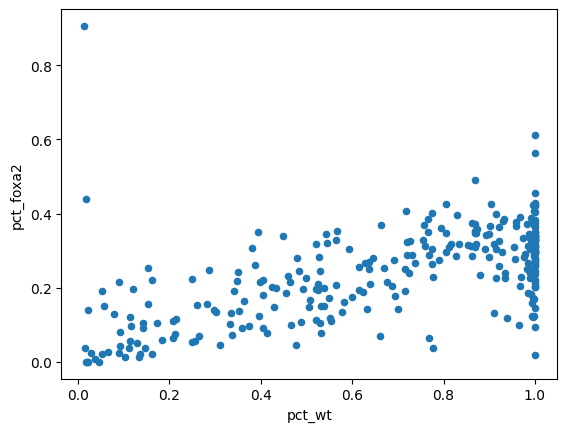

In [13]:
df.plot(kind='scatter', x = 'pct_wt', y =  'pct_foxa2')

In [14]:
outDir 

'../images_data/results/Pax6KO_WTchim_d4'

In [16]:
df.to_csv(os.path.join(outDir, "cyst_size_genotype_FoxA2_Pax6_cystThresholds_testMeanThreshodling_test_jetraw_compression.csv"), index=True, header=True)

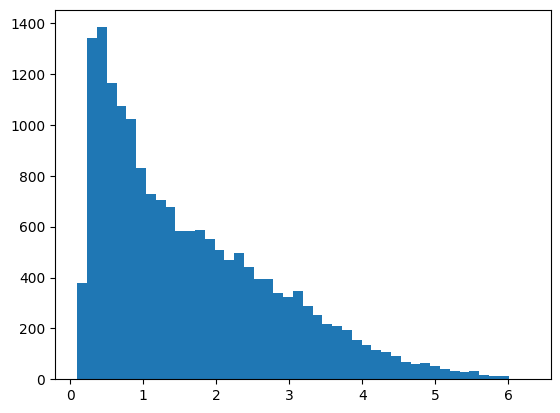

In [17]:
plt.hist(foxa2_wt, bins='auto')  # arguments are passed to np.histogram
#plt.title("Histogram with 'auto' bins")
plt.show()

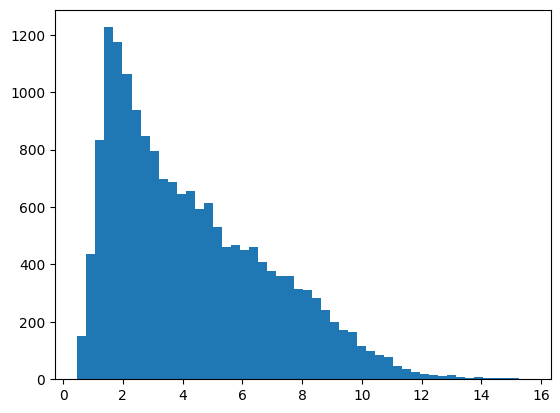

In [18]:
plt.hist(pax6_wt, bins='auto')  # arguments are passed to np.histogram
#plt.title("Histogram with 'auto' bins")
plt.show()

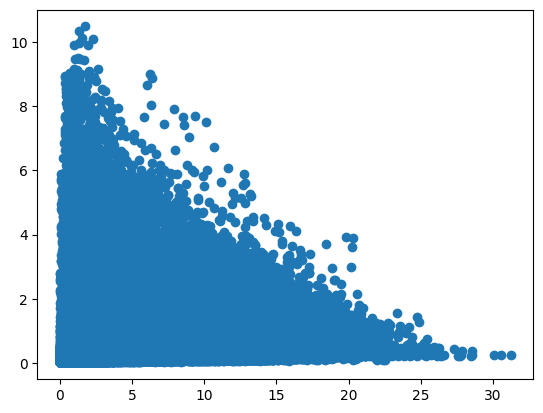

In [19]:
plt.scatter(genotype_wt, genotype_ko) 
# To show the plot
plt.show()

In [40]:
#genotype_wt
genotype_all = np.concatenate((genotype_wt, genotype_ko), axis=0)
print(genotype_all.size)
sels = np.where(genotype_all>0)
genotype_sels = genotype_all[sels]
print(genotype_sels.size)
genotype_sels

121968
121968


array([0.07006531, 0.06854353, 0.06296367, ..., 0.03537736, 0.04874214,
       0.06053459])

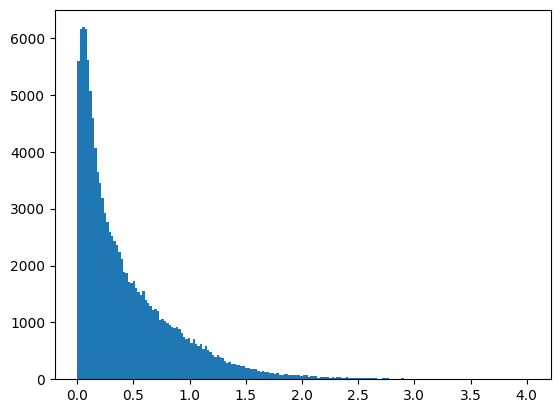

In [41]:
plt.hist(genotype_sels, bins='auto')  # arguments are passed to np.histogram
#plt.title("Histogram with 'auto' bins")
plt.show()

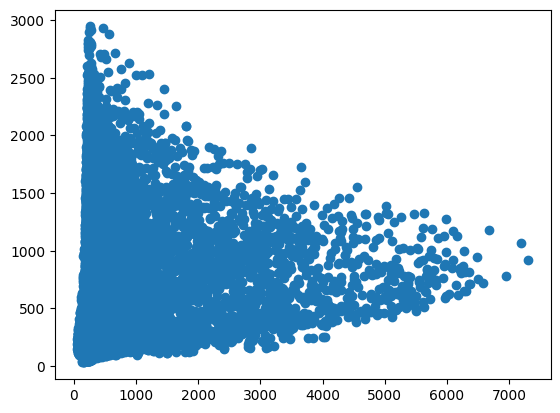

In [101]:
plt.scatter(foxa2_wt, pax6_wt) 
# To show the plot
plt.show()

In [ ]:
############################################################
###
### FoxA2 KO 
### counting the voxels based on the masked and cyst-level background 
###
############################################################

In [8]:
ImageDir = "../images_data/d4_10x_FoxA2KO_WTchim"
outDir = "../images_data/results/FoxAKO_WTchim_d4"

if not os.path.exists(outDir):
    os.mkdir(outDir)
#os.path.exists(outDir)

In [11]:
fileName = '241023_10x_d4-2umZ_3-FS-WG_RA_FA2-Px6_E7_63_01_isotropic'

In [12]:
mask = imread(os.path.join(CPoutDir, str(fileName + "_C5_CystMask.tiff"))) # mask segmeted cysts
#C1 = imread(os.path.join(CPoutDir, str(fileName + "_FoxA2mask.tiff"))) # FoxA2, nuclei
#C2 = imread(os.path.join(CPoutDir, str(fileName + "_P6KOSCmask.tiff"))) # Pax6-KO genotype Scarlet, nuclei
#C3 = imread(os.path.join(CPoutDir, str(fileName + "_WTGFPmask.tiff"))) # WT genotype GFP, whole cell 
#C4 = imread(os.path.join(CPoutDir, str(fileName + "_Pax6mask.tiff"))) # Pax6, nuclei
C1 = imread(os.path.join(ImageDir, str(fileName + "_C1.tif"))) # FoxA2, nuclei
C2 = imread(os.path.join(ImageDir, str(fileName + "_C2.tif"))) # FoxA2-KO genotype Scarlet, nuclei
C3 = imread(os.path.join(ImageDir, str(fileName + "_C3.tif"))) # WT genotype GFP, whole cell 
C4 = imread(os.path.join(ImageDir, str(fileName + "_C4.tif"))) # Pax6, nuclei

NameError: name 'CPoutDir' is not defined

In [67]:
C1 = C1 / np.quantile(C1, 0.99)
C2 = C2 / np.quantile(C2, 0.99)
C3 = C3 / np.quantile(C3, 0.99)
C4 = C4 / np.quantile(C4, 0.99)

In [68]:
from skimage import measure
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank

labels_mask, nb_cyst = measure.label(mask, return_num = True)

In [69]:
nb_cyst

35

In [9]:
import pandas as pd
from skimage import measure
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank

ImageDir = "../images_data/d4_10x_FoxA2KO_WTchim"
outDir = "../images_data/results/FoxAKO_WTchim_d4"

if not os.path.exists(outDir):
    os.mkdir(outDir)

from skimage import measure
data = {"image": [], "cyst_index": [], "cyst_size": [],
        "nb_wt_all_global": [], "nb_ko_all_global": [], "nb_foxa2_all_global": [], "nb_pax6_all_global": [],
        "nb_wt_all": [], "nb_ko_all": [], "nb_foxa2_all": [], "nb_pax6_all": [], "nb_double_all": [],
        "nb_foxa2_wt": [], "nb_pax6_wt": [],  "nb_foxa2_ko": [], "nb_pax6_ko": [],
        "nb_foxa2_wt_ll": [], "nb_pax6_wt_ll": [],  "nb_foxa2_ko_ll": [], "nb_pax6_ko_ll": [],
        "nb_foxa2_wt_lg": [], "nb_pax6_wt_lg": [],  "nb_foxa2_ko_lg": [], "nb_pax6_ko_lg": [],
        "nb_foxa2_wt_gg": [], "nb_pax6_wt_gg": [],  "nb_foxa2_ko_gg": [], "nb_pax6_ko_gg": []
        
       }

df = pd.DataFrame(data)
df

,image,cyst_index,cyst_size,nb_wt_all_global,nb_ko_all_global,nb_foxa2_all_global,nb_pax6_all_global,nb_wt_all,nb_ko_all,nb_foxa2_all,...,nb_foxa2_ko_ll,nb_pax6_ko_ll,nb_foxa2_wt_lg,nb_pax6_wt_lg,nb_foxa2_ko_lg,nb_pax6_ko_lg,nb_foxa2_wt_gg,nb_pax6_wt_gg,nb_foxa2_ko_gg,nb_pax6_ko_gg


In [10]:
for nm in os.listdir(ImageDir):
    if "_C5_CystMask.tiff" in nm:
        #print(nm)
        fileName = nm.replace('_C5_CystMask.tiff','')
        #files += [nm]
        print(fileName)
        #make_composite_C5(newName, ImageDir, outDir)
        
        mask = imread(os.path.join(ImageDir, str(fileName + "_C5_CystMask.tiff"))) # mask segmeted cysts
        C1 = imread(os.path.join(ImageDir, str(fileName + "_C1.tif"))) # FoxA2, nuclei
        C2 = imread(os.path.join(ImageDir, str(fileName + "_C2.tif"))) # FoxA2-KO genotype Scarlet, nuclei
        C3 = imread(os.path.join(ImageDir, str(fileName + "_C3.tif"))) # WT genotype GFP, whole cell 
        C4 = imread(os.path.join(ImageDir, str(fileName + "_C4.tif"))) # Pax6, nuclei
        
        C1 = C1 / np.quantile(C1, 0.95)
        C2 = C2 / np.quantile(C2, 0.95)
        C3 = C3 / np.quantile(C3, 0.95)
        C4 = C4 / np.quantile(C4, 0.95)
        
        labels_mask, nb_cyst = measure.label(mask, return_num = True)
        
        ######
        ## global thresholding 
        #cutoff_fako_image = threshold_otsu(C2)
        #cutoff_pxko_image = threshold_otsu(C3)
        #cutoff_foxa2_image = threshold_otsu(C1)
        #cutoff_pax6_image = threshold_otsu(C4)
        cutoff_wt_image = filters.threshold_otsu(C3)
        cutoff_ko_image = filters.threshold_otsu(C2)
        
        #cutoff_foxa2_image = filters.threshold_mean(C1)
        #cutoff_pax6_image = filters.threshold_mean(C4)
        
        cutoff_foxa2_image = filters.threshold_otsu(C1)
        cutoff_pax6_image = filters.threshold_otsu(C4)
        
        
        for i in range(nb_cyst+1):
            if i > 0:
                
                cyst_index = np.where(labels_mask == i)
                
                #print(cyst_index[0].size)
                genotype_wt = C3[cyst_index]
                genotype_ko = C2[cyst_index]
                pax6 = C4[cyst_index]
                foxa2 = C1[cyst_index]
                
                ########
                ## local thresholdes
                ########
                cutoff_wt = threshold_otsu(genotype_wt)
                cutoff_ko = threshold_otsu(genotype_ko)
                cutoff_foxa2 = filters.threshold_mean(foxa2)
                cutoff_pax6 = filters.threshold_mean(pax6)
                
                ###########
                # genotype and FoxA2 proportion in whole cyst
                ###########
                index_foxa2_all_global = np.where((foxa2 > cutoff_foxa2_image) & (pax6 < cutoff_pax6_image))
                index_pax6_all_global = np.where((foxa2 < cutoff_foxa2_image) & (pax6 > cutoff_pax6_image))
                
                index_wt_all_global = np.where((genotype_wt > cutoff_wt_image) & (genotype_ko < cutoff_ko_image))
                index_ko_all_global = np.where((genotype_wt < cutoff_wt_image) & (genotype_ko > cutoff_ko_image))
                
                index_foxa2_all = np.where((foxa2 > cutoff_foxa2) & (pax6 < cutoff_pax6))
                index_pax6_all = np.where((foxa2 < cutoff_foxa2) & (pax6 > cutoff_pax6))
                index_double_all = np.where((foxa2 > cutoff_foxa2) & (pax6 > cutoff_pax6))
                
                index_wt_all = np.where((genotype_wt > cutoff_wt) & (genotype_ko < cutoff_ko))
                index_ko_all = np.where((genotype_wt < cutoff_wt) & (genotype_ko > cutoff_ko))
                
                
                #######
                ## original computatoin of WT and KO genotype 
                #######
                sels = np.where((genotype_wt > cutoff_wt) | (genotype_ko > cutoff_ko))
                
                genotype_wt_sels = genotype_wt[sels]
                genotype_ko_sels = genotype_ko[sels]
                pax6_sels = pax6[sels]
                foxa2_sels = foxa2[sels]
                
                index_wt = np.where(genotype_wt_sels > genotype_ko_sels)
                index_ko = np.where(genotype_wt_sels <= genotype_ko_sels)
                #print(index_wt[0].size/sels[0].size)
                
                 # FoxA2+ or Pax6+ voxel counts in genotyep positive voxels
                index_foxa2_sels = np.where((foxa2_sels > cutoff_foxa2) & (pax6_sels < cutoff_pax6))
                index_pax6_sels = np.where((foxa2_sels < cutoff_foxa2) & (pax6_sels > cutoff_pax6))
                
                if index_wt[0].size > 0:
                    #pax6_wt = pax6[geno_wt]
                    #foxa2_wt = foxa2[geno_wt]
                    #index_foxa2 = np.where(foxa2_wt > 0)
                    #index_pax6 = np.where(pax6_wt > 0)
                    foxa2_wt = foxa2_sels[index_wt]
                    pax6_wt = pax6_sels[index_wt]
                    
                    index_foxa2_wt = np.where((foxa2_wt > cutoff_foxa2) & (pax6_wt < cutoff_pax6))
                    index_pax6_wt = np.where((foxa2_wt < cutoff_foxa2) & (pax6_wt > cutoff_pax6))
                    #print(index_foxa2[0].size/(index_foxa2[0].size + index_pax6[0].size))
                    
                    #foxa2_wt = foxa2[index_wt]
                    #pax6_wt = pax6[index_wt]
                    foxa2_ko = foxa2_sels[index_ko]
                    pax6_ko = pax6_sels[index_ko]
                    index_foxa2_ko = np.where((foxa2_ko > cutoff_foxa2) & (pax6_ko < cutoff_pax6))
                    index_pax6_ko = np.where((foxa2_ko < cutoff_foxa2) & (pax6_ko > cutoff_pax6))
                   
                #######
                ## second computaton of WT and KO genotype without cross channel comparison
                #######
                index_wt_2 = np.where((genotype_wt > cutoff_wt) & (genotype_ko < cutoff_ko))
                index_ko_2 = np.where((genotype_wt < cutoff_wt) & (genotype_ko > cutoff_ko))
                
                if index_wt_2[0].size > 0:
                    foxa2_wt_2 = foxa2[index_wt_2]
                    pax6_wt_2 = pax6[index_wt_2]
                    
                    index_foxa2_wt_2 = np.where((foxa2_wt_2 > cutoff_foxa2) & (pax6_wt_2 < cutoff_pax6))
                    index_pax6_wt_2 = np.where((foxa2_wt_2 < cutoff_foxa2) & (pax6_wt_2 > cutoff_pax6))
                    
                    foxa2_ko_2 = foxa2[index_ko_2]
                    pax6_ko_2 = pax6[index_ko_2]
                    index_foxa2_ko_2 = np.where((foxa2_ko_2 > cutoff_foxa2) & (pax6_ko_2 < cutoff_pax6))
                    index_pax6_ko_2 = np.where((foxa2_ko_2 < cutoff_foxa2) & (pax6_ko_2 > cutoff_pax6))
                
                
                
                #######
                ## third computaton of WT and KO genotype using global thresholds 
                #######
                index_wt_3 = np.where((genotype_wt > cutoff_wt_image) & (genotype_ko < cutoff_ko_image))
                index_ko_3 = np.where((genotype_wt < cutoff_wt_image) & (genotype_ko > cutoff_ko_image))
                
                if index_wt_3[0].size > 0:
                    foxa2_wt_3 = foxa2[index_wt_3]
                    pax6_wt_3 = pax6[index_wt_3]
                    
                    index_foxa2_wt_3 = np.where((foxa2_wt_3 > cutoff_foxa2) & (pax6_wt_3 < cutoff_pax6))
                    index_pax6_wt_3 = np.where((foxa2_wt_3 < cutoff_foxa2) & (pax6_wt_3 > cutoff_pax6))
                    
                    index_foxa2_wt_4 = np.where((foxa2_wt_3 > cutoff_foxa2_image) & (pax6_wt_3 < cutoff_pax6_image))
                    index_pax6_wt_4 = np.where((foxa2_wt_3 < cutoff_foxa2_image) & (pax6_wt_3 > cutoff_pax6_image))
                    
                    foxa2_ko_3 = foxa2[index_ko_3]
                    pax6_ko_3 = pax6[index_ko_3]
                    index_foxa2_ko_3 = np.where((foxa2_ko_3 > cutoff_foxa2) & (pax6_ko_3 < cutoff_pax6))
                    index_pax6_ko_3 = np.where((foxa2_ko_3 < cutoff_foxa2) & (pax6_ko_3 > cutoff_pax6))
                    
                    index_foxa2_ko_4 = np.where((foxa2_ko_3 > cutoff_foxa2_image) & (pax6_ko_3 < cutoff_pax6_image))
                    index_pax6_ko_4 = np.where((foxa2_ko_3 < cutoff_foxa2_image) & (pax6_ko_3 > cutoff_pax6_image))
                    
                
                df.loc[len(df)] = [fileName, i, cyst_index[0].size,
                                   index_wt_all_global[0].size, index_ko_all_global[0].size,  index_foxa2_all_global[0].size, index_pax6_all_global[0].size,  
                                   index_wt_all[0].size, index_ko_all[0].size,  index_foxa2_all[0].size, index_pax6_all[0].size, index_double_all[0].size,
                                   
                                   index_foxa2_wt[0].size, index_pax6_wt[0].size, index_foxa2_ko[0].size, index_pax6_ko[0].size,
                                   index_foxa2_wt_2[0].size, index_pax6_wt_2[0].size, index_foxa2_ko_2[0].size, index_pax6_ko_2[0].size,
                                   index_foxa2_wt_3[0].size, index_pax6_wt_3[0].size, index_foxa2_ko_3[0].size, index_pax6_ko_3[0].size,
                                   index_foxa2_wt_4[0].size, index_pax6_wt_4[0].size, index_foxa2_ko_4[0].size, index_pax6_ko_4[0].size,
                                  ]
                
                

241023_10x_d4-2umZ_3-FS-WG_RA_FA2-Px6_E7_61_01_isotropic
241023_10x_d4-2umZ_3-FS-WG_RA_FA2-Px6_E7_62_01_isotropic
241023_10x_d4-2umZ_3-FS-WG_RA_FA2-Px6_E7_63_01_isotropic
241023_10x_d4-2umZ_3-FS-WG_RA_FA2-Px6_E8_65_01_isotropic
241023_10x_d4-2umZ_3-FS-WG_RA_FA2-Px6_E8_66_01_isotropic
241023_10x_d4-2umZ_3-FS-WG_RA_FA2-Px6_E8_67_01_isotropic
241023_10x_d4-2umZ_3-FS-WG_RA_FA2-Px6_E9_69_01_isotropic
241023_10x_d4-2umZ_3-FS-WG_RA_FA2-Px6_E9_70_01_isotropic
241023_10x_d4-2umZ_3-FS-WG_RA_FA2-Px6_E9_71_01_isotropic


In [11]:
df

,image,cyst_index,cyst_size,nb_wt_all_global,nb_ko_all_global,nb_foxa2_all_global,nb_pax6_all_global,nb_wt_all,nb_ko_all,nb_foxa2_all,...,nb_foxa2_ko_ll,nb_pax6_ko_ll,nb_foxa2_wt_lg,nb_pax6_wt_lg,nb_foxa2_ko_lg,nb_pax6_ko_lg,nb_foxa2_wt_gg,nb_pax6_wt_gg,nb_foxa2_ko_gg,nb_pax6_ko_gg
0,241023_10x_d4-2umZ_3-FS-WG_RA_FA2-Px6_E7_61_01...,1,39740,23615,0,2373,11596,9273,7621,5053,...,1551,388,4091,8555,0,0,2241,11519,0,0
1,241023_10x_d4-2umZ_3-FS-WG_RA_FA2-Px6_E7_61_01...,2,37536,10340,6134,2822,13591,6664,9573,5670,...,116,7324,4257,1273,18,5335,2429,2910,2,5665
2,241023_10x_d4-2umZ_3-FS-WG_RA_FA2-Px6_E7_61_01...,3,80200,1501,48760,39,50934,7299,19562,6846,...,943,10965,218,483,4368,19043,21,1332,1,40329
3,241023_10x_d4-2umZ_3-FS-WG_RA_FA2-Px6_E7_61_01...,4,80692,19659,22758,2031,44182,15560,23670,8341,...,811,13587,3646,9823,772,12901,1310,15261,47,19887
4,241023_10x_d4-2umZ_3-FS-WG_RA_FA2-Px6_E7_61_01...,5,19452,12316,1,119,8458,8127,106,1375,...,0,32,1102,5255,0,0,119,8381,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,241023_10x_d4-2umZ_3-FS-WG_RA_FA2-Px6_E9_71_01...,26,536,31,25,13,126,32,152,50,...,1,126,28,0,0,24,13,0,0,23
340,241023_10x_d4-2umZ_3-FS-WG_RA_FA2-Px6_E9_71_01...,27,12612,5977,14,1735,1963,4816,472,1909,...,0,146,1529,1903,0,14,1671,1818,0,10
341,241023_10x_d4-2umZ_3-FS-WG_RA_FA2-Px6_E9_71_01...,28,24680,5733,5331,1883,3352,6385,4248,2916,...,444,1133,765,2118,614,1225,883,2817,334,242
342,241023_10x_d4-2umZ_3-FS-WG_RA_FA2-Px6_E9_71_01...,29,17508,0,4118,0,11408,644,7276,4023,...,1028,1794,765,2118,614,1225,883,2817,334,242


In [12]:
#df.plot(kind='scatter', x = 'pct_ko', y =  'pct_foxa2')

In [13]:
outDir 

'../images_data/results/FoxAKO_WTchim_d4'

In [14]:
df.to_csv(os.path.join(outDir, "cyst_size_genotype_FoxA2_Pax6_cystThresholds_test_otsuThresholdGenotype_meanThresholdFoxA2_originalGenetype_Normallization_globallocalThreshods_v10.csv"), 
          index=True, header=True)

In [ ]:
#############################################
## Not used here 
## PAX6 KO with CP binary images by Hannah
#############################################

In [127]:
import pandas as pd
from skimage import measure
data = {"image": [], "cyst_index": [], "cyst_size": [],  "pct_genotype": [], "pct_wt": [], "pct_foxa2": [], "pct_pax6": []}
df = pd.DataFrame(data)
df

,image,cyst_index,cyst_size,pct_genotype,pct_wt,pct_foxa2,pct_pax6


In [129]:
nb_wt = []
nb_wt_foxa2 = []
nb_wt_pax6 = []

nb_ko = []
nb_ko_foxa2 = []
nb_ko_pax6 = []

In [130]:
CPoutDir = "../images_data/CPouts2"
for nm in os.listdir(CPoutDir):
    if "_CystMask.tiff" in nm:
        #print(nm)
        fileName = nm.replace('_CystMask.tiff','')
        #files += [nm]
        print(fileName)
        #make_composite_C5(newName, ImageDir, outDir)
        
        mask = imread(os.path.join(CPoutDir, str(fileName + "_CystMask.tiff"))) # mask segmeted cysts
        C1 = imread(os.path.join(CPoutDir, str(fileName + "_FoxA2mask.tiff"))) # FoxA2, nuclei
        C2 = imread(os.path.join(CPoutDir, str(fileName + "_P6KOSCmask.tiff"))) # Pax6-KO genotype Scarlet, nuclei
        C3 = imread(os.path.join(CPoutDir, str(fileName + "_WTGFPmask.tiff"))) # WT genotype GFP, whole cell 
        C4 = imread(os.path.join(CPoutDir, str(fileName + "_Pax6mask.tiff"))) # Pax6, nuclei
        
        labels_mask, nb_cyst = measure.label(mask, return_num = True)

        for i in range(nb_cyst+1):
            if i > 0:
                #print(i) # prints: -1, 0, 1, 2, 3, 4,
                cyst_index = np.where(labels_mask == i)
                genotype_wt = C3[cyst_index]
                genotype_ko = C2[cyst_index]
                pax6 = C4[cyst_index]
                foxa2 = C1[cyst_index]
        
                geno_wt = np.where((genotype_wt > 0) & (genotype_ko == 0)) # for and
                geno_ko = np.where((genotype_wt == 0) & (genotype_ko > 0)) # for and
                
                nb_wt += [geno_wt[0].size]
                pax6_wt = pax6[geno_wt]
                foxa2_wt = foxa2[geno_wt]
                index_foxa2 = np.where(foxa2_wt > 0)
                index_pax6 = np.where(pax6_wt > 0)
                
                nb_wt_foxa2 += [index_foxa2[0].size]
                nb_wt_pax6 += [index_pax6[0].size]
                
                nb_ko += [geno_ko[0].size]
                pax6_ko = pax6[geno_ko]
                foxa2_ko = foxa2[geno_ko]
                index_foxa2_ko = np.where(foxa2_ko > 0)
                index_pax6_ko = np.where(pax6_ko > 0)
                
                nb_ko_foxa2 += [index_foxa2_ko[0].size]
                nb_ko_pax6 += [index_pax6_ko[0].size]
                
                
                if geno_wt[0].size > 0:
                    pax6_wt = pax6[geno_wt]
                    foxa2_wt = foxa2[geno_wt]
                    index_foxa2 = np.where(foxa2_wt > 0)
                    index_pax6 = np.where(pax6_wt > 0)
                    
                    df.loc[len(df)] = [fileName, i,  cyst_index[0].size, 
                                       (geno_ko[0].size + geno_wt[0].size)/cyst_index[0].size, 
                                        geno_wt[0].size/(geno_ko[0].size + geno_wt[0].size), 
                                        index_foxa2[0].size/geno_wt[0].size, 
                                        index_pax6[0].size/geno_wt[0].size]

241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F7_85_01_isotropic_C5
241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F7_86_01_isotropic_C5
241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F7_87_01_isotropic_C5
241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F8_89_01_isotropic_C5
241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F8_90_01_isotropic_C5
241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F8_91_01_isotropic_C5
241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F9_93_01_isotropic_C5
241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F9_94_01_isotropic_C5
241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F9_95_01_isotropic_C5


In [131]:
print(np.sum(nb_wt))
print(np.sum(nb_ko))
print(np.sum(nb_wt_foxa2)/np.sum(nb_wt))
print(np.sum(nb_wt_pax6)/np.sum(nb_wt))

print(np.sum(nb_ko_foxa2)/np.sum(nb_ko))
print(np.sum(nb_ko_pax6)/np.sum(nb_ko))


2878203
4250792
0.33603814602375165
0.4960226919366007
0.571094986534274
0.027127415314604903


In [132]:
df 

,image,cyst_index,cyst_size,pct_genotype,pct_wt,pct_foxa2,pct_pax6
0,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F7_85_01...,1,58628,0.485365,0.332338,0.498995,0.450248
1,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F7_85_01...,2,30408,0.499474,0.138662,0.701330,0.001425
2,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F7_85_01...,3,60392,0.496788,0.700287,0.386816,0.549691
3,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F7_85_01...,4,52778,0.608492,0.995983,0.290721,0.734759
4,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F7_85_01...,5,40924,0.286531,0.533515,0.397219,0.453325
...,...,...,...,...,...,...,...
281,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F9_95_01...,56,44664,0.519210,0.028374,0.364742,0.346505
282,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F9_95_01...,58,516,0.934109,1.000000,0.000000,0.197095
283,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F9_95_01...,59,6968,0.565442,0.999746,0.743336,0.233054
284,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F9_95_01...,60,26028,0.510719,0.884225,0.225370,0.482729


In [133]:
df.to_csv(os.path.join(outDir, "cyst_size_genotype_FoxA2_Pax6.csv"), index=True, header=True)

In [17]:
outDir
df = pd.read_csv(os.path.join(outDir, "genotype_FoxA2_Pax6.csv"), index_col = 0) 

In [18]:
df

,image,cyst_index,pct_genotype,pct_wt,pct_foxa2,pct_pax6
0,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F7_85_01...,1,0.485365,0.332338,0.498995,0.450248
1,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F7_85_01...,2,0.499474,0.138662,0.701330,0.001425
2,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F7_85_01...,3,0.496788,0.700287,0.386816,0.549691
3,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F7_85_01...,4,0.608492,0.995983,0.290721,0.734759
4,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F7_85_01...,5,0.286531,0.533515,0.397219,0.453325
...,...,...,...,...,...,...
281,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F9_95_01...,56,0.519210,0.028374,0.364742,0.346505
282,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F9_95_01...,58,0.934109,1.000000,0.000000,0.197095
283,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F9_95_01...,59,0.565442,0.999746,0.743336,0.233054
284,241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F9_95_01...,60,0.510719,0.884225,0.225370,0.482729


<Axes: xlabel='cyst_size', ylabel='pct_foxa2'>

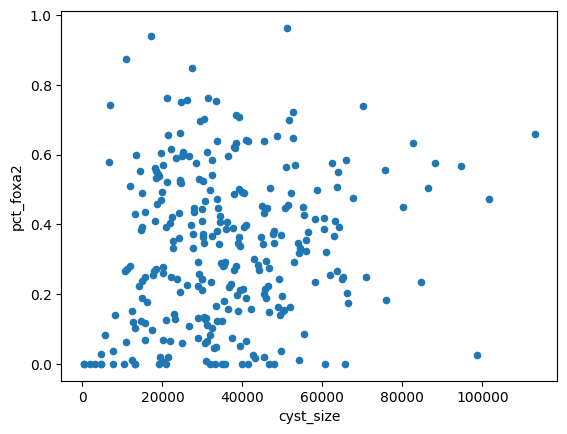

In [135]:
df.plot(kind='scatter', x = 'cyst_size', y =  'pct_foxa2')

<Axes: xlabel='cyst_size', ylabel='pct_pax6'>

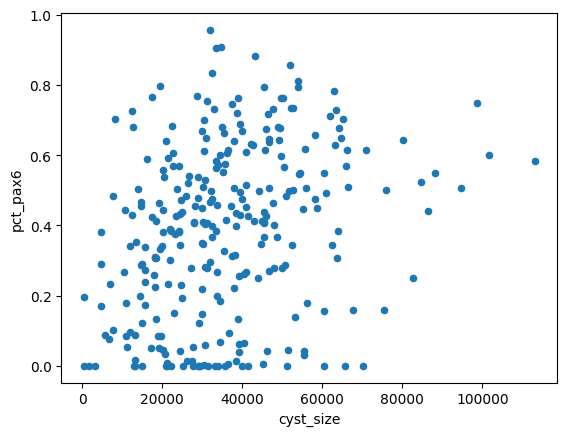

In [136]:
df.plot(kind='scatter', x = 'cyst_size', y =  'pct_pax6')

In [22]:
dff = df[["pct_wt", "pct_foxa2"]]
bins = 10
data_cut = pd.cut(dff.pct_wt,bins)           #we cut the data following the bins
grp = dff.groupby(by = data_cut)        #we group the data by the cut

ret = grp.aggregate(np.median)         #we produce an aggregate representation (median) of each bin
ret

/tmp/ipykernel_67286/2153116893.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = dff.groupby(by = data_cut)        #we group the data by the cut
/tmp/ipykernel_67286/2153116893.py:6: FutureWarning: The provided callable <function median at 0x2aeaa281a790> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  ret = grp.aggregate(np.median)         #we produce an aggregate representation (median) of each bin


,pct_wt,pct_foxa2
pct_wt,,
"(-0.000908, 0.1]",0.011182,0.316096
"(0.1, 0.2]",0.138052,0.372969
"(0.2, 0.3]",0.250484,0.369866
"(0.3, 0.4]",0.339594,0.390062
"(0.4, 0.5]",0.476663,0.393534
"(0.5, 0.6]",0.562820,0.397484
"(0.6, 0.7]",0.664430,0.337516
"(0.7, 0.8]",0.747142,0.400039
"(0.8, 0.9]",0.844303,0.499484


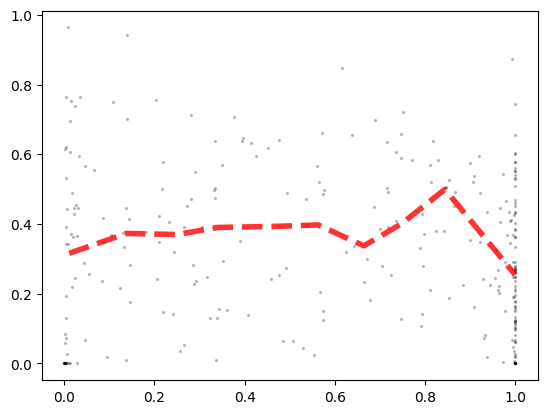

In [23]:
 #plotting
 plt.scatter(dff.pct_wt,dff.pct_foxa2,color='k',alpha=.2,s=2)
 plt.plot(ret.pct_wt,ret.pct_foxa2,'r--',lw=4,alpha=.8)
 plt.show()

In [ ]:
bins = np.linspace(X.min(),X.max(), total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(X,bins)
running_median = [np.median(Y[idx==k]) for k in range(total_bins)]

ZeroDivisionError: division by zero

In [23]:
cyst_index

(array([ 5,  5,  5, ..., 62, 62, 62]),
 array([341, 341, 341, ..., 358, 358, 358]),
 array([200, 201, 202, ..., 199, 200, 201]))

In [25]:
genotype_wt

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

In [120]:
geno_wt = np.where((genotype_wt > 0) & (genotype_ko == 0)) # for and
geno_ko = np.where((genotype_wt == 0) & (genotype_ko > 0)) # for and
#np.where((condition 1) | (condition 2)) # for or



In [121]:
geno_wt[0].size

0

In [122]:
geno_ko[0].size

16123

In [96]:
(geno_ko[0].size + geno_wt[0].size)/cyst_index[0].size
geno_wt[0].size/(geno_ko[0].size + geno_wt[0].size)

0.6238930928996941

In [97]:
pax6_wt = pax6[geno_wt]
foxa2_wt = foxa2[geno_wt]

In [102]:
#plt.hist(genotype_wt, bins=100, color='skyblue', edgecolor='black')
index_foxa2 = np.where(foxa2_wt > 0)
index_foxa2[0].size/geno_wt[0].size

0.3207741935483871

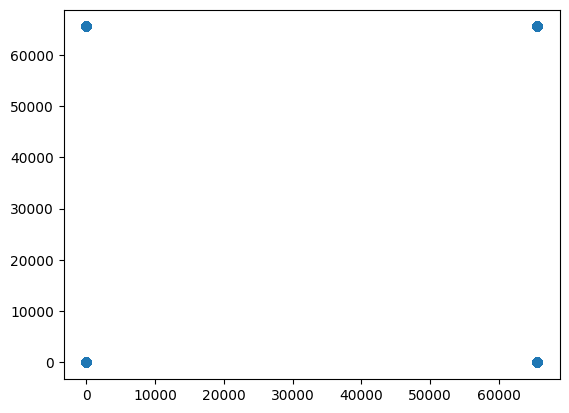

In [26]:
plt.scatter(genotype_wt, foxa2)
 
# To show the plot
plt.show()

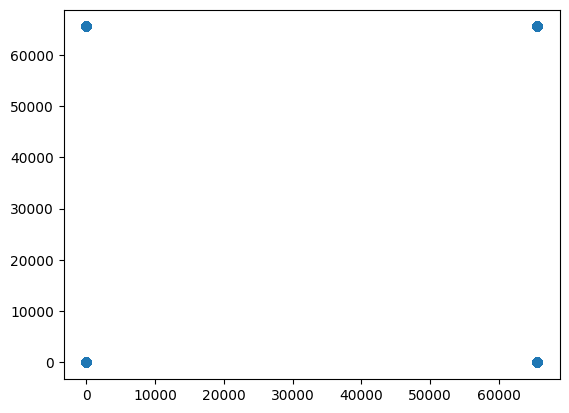

In [28]:
plt.scatter(genotype_wt, genotype_ko)
# To show the plot
plt.show()

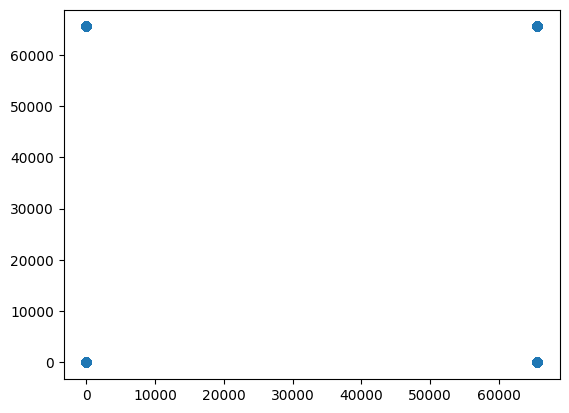

In [31]:
plt.scatter(genotype_ko, pax6)
 
# To show the plot
plt.show()


0.3432126071329831

In [42]:
genotype_ko.size

60984

In [43]:
pax6.size

60984

In [26]:
#plt.hist(genotype_wt, bins=100, color='skyblue', edgecolor='black')

In [ ]:
# analyse objects
#properties = measure.regionprops(label_image, intensity_image=image)